# Feature Engineering

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 18})

In [2]:
# Create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data

In [3]:
df_raw = spark.read.csv('../data/emdat_public_cleaned.csv', inferSchema = True, header = True) 
df = df_raw.toPandas() # convert into pandas df

print("Data size:", df.shape) # print data size
df.columns = [x.lower() for x in df.columns] # column names in lower case
df.head()

Data size: (15901, 20)


,iso,country,region,continent,year,disaster_type,latitude,longitude,local_time,start_month,total_deaths,no_injured,no_affected,no_homeless,total_affected,total_damages_(us$),cpi,local_hour,year_in_decade,no_occurrence
0,CPV,Cabo Verde,Western Africa,Africa,1900,Drought,NaN,NaN,None,NaN,11000.0,NaN,NaN,NaN,NaN,NaN,3.261389,NaN,1900,7.0
1,IND,India,Southern Asia,Asia,1900,Drought,NaN,NaN,None,NaN,1250000.0,NaN,NaN,NaN,NaN,NaN,3.261389,NaN,1900,7.0
2,GTM,Guatemala,Central America,Americas,1902,Earthquake,14.0,-91.0,20:20,4.0,2000.0,NaN,NaN,NaN,NaN,25000.0,3.391845,20.0,1900,10.0
3,GTM,Guatemala,Central America,Americas,1902,Volcanic activity,NaN,NaN,None,4.0,1000.0,NaN,NaN,NaN,NaN,NaN,3.391845,NaN,1900,10.0
4,GTM,Guatemala,Central America,Americas,1902,Volcanic activity,NaN,NaN,None,10.0,6000.0,NaN,NaN,NaN,NaN,NaN,3.391845,NaN,1900,10.0


# Data types and missing values
As indicated in the [data source](https://www.emdat.be), the missing values in some numerical columns should be set to zero. However, missing values in other columns such as local_hour, start_month will be imputed in data pre-processing 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15901 entries, 0 to 15900
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   iso                  15901 non-null  object 
 1   country              15901 non-null  object 
 2   region               15901 non-null  object 
 3   continent            15901 non-null  object 
 4   year                 15901 non-null  int32  
 5   disaster_type        15901 non-null  object 
 6   latitude             2721 non-null   float64
 7   longitude            2722 non-null   float64
 8   local_time           1097 non-null   object 
 9   start_month          15516 non-null  float64
 10  total_deaths         11281 non-null  float64
 11  no_injured           3832 non-null   float64
 12  no_affected          9044 non-null   float64
 13  no_homeless          2414 non-null   float64
 14  total_affected       11421 non-null  float64
 15  total_damages_(us$)  5178 non-null  

In [5]:
# Compute percentage of missing values
missing_values = (df.isnull().sum()/df.shape[0])*100

# Dataframe of missing values
missing_df =pd.DataFrame({'Variable': missing_values.index, 
                          '% missing values': missing_values.values})
missing_df\
    .sort_values(by = '% missing values', ascending = False)\
        .reset_index(drop = True)

,Variable,% missing values
0,local_hour,93.107352
1,local_time,93.101063
2,no_homeless,84.818565
3,latitude,82.887869
4,longitude,82.881580
5,no_injured,75.900887
6,total_damages_(us$),67.436010
7,no_affected,43.123074
8,total_deaths,29.054776
9,total_affected,28.174329


In [6]:
# Fill missing values with zeros in  cols list
cols = ['total_deaths', 'no_injured', 'total_damages_(us$)',
        'no_affected', 'no_homeless', 'total_affected']    
for col in cols:
    df[col] = df[col].fillna(0) 

# Occurrence per continent

In [7]:
df_cont = pd.DataFrame(df.continent.value_counts())
df_cont.reset_index(level=0,inplace=True)
df_cont.rename(columns = {'continent':'occur_per_contnt',  'index':'continent'},inplace=True)
df_cont

,continent,occur_per_contnt
0,Asia,6411
1,Americas,3907
2,Africa,2908
3,Europe,1962
4,Oceania,713


In [8]:
# left join to the main dataframe
df = df.merge(df_cont, how = 'left', on = 'continent')

# Disaster types
The infrequent levels will be grouped together

In [9]:
df.disaster_type.value_counts()

Flood                    5447
Storm                    4434
Earthquake               1534
Epidemic                 1496
Landslide                 768
Drought                   758
Extreme temperature       601
Wildfire                  456
Volcanic activity         259
Insect infestation         96
Mass movement (dry)        48
Fog                         1
Animal accident             1
Impact                      1
Glacial lake outburst       1
Name: disaster_type, dtype: int64

In [10]:
dict_map = {'Wildfire':'Other', 'Volcanic activity':'Other',
'Insect infestation':'Other', 'Mass movement (dry)':'Other', 
'Glacial lake outburst':'Other','Animal accident':'Other', 
'Impact':'Other', 'Fog':'Other'}

df.disaster_type.replace(dict_map, inplace = True)

In [11]:
df.disaster_type.value_counts()

Flood                  5447
Storm                  4434
Earthquake             1534
Epidemic               1496
Other                   863
Landslide               768
Drought                 758
Extreme temperature     601
Name: disaster_type, dtype: int64

# Features based on occurrence, continent, and year

In [12]:
#  Affected features
df['no_affected_per_occur'] = df['no_affected']/df['no_occurrence']
df['no_affected_per_contnt'] = df['no_affected']/df['occur_per_contnt']
df['no_affected_per_year'] = df['no_affected']/df['year']

In [13]:
df['flood_storm_ind'] = np.where(df.disaster_type == 'Flood', 'Y',
                                    np.where(df.disaster_type == 'Storm', 'Y', 'N')
                                    )

In [13]:
# cols = ['no_affected_per_year', 'no_affected_per_contnt', 'no_affected_per_occur',
#        'total_deaths_per_year', 'total_deaths_per_contnt', 'total_deaths_per_occur',
#        'no_homeless_per_year', 'no_homeless_per_contnt', 'no_homeless_per_occur']
# df.drop(cols, axis = 1, inplace = True)

# Correlation with target variable

In [14]:
corr_matrix = df.drop(['year_in_decade', 'local_hour', 'longitude', 'latitude'], axis = 1).corr()
corr_matrix['no_affected'].sort_values(ascending = False)

no_affected               1.000000
no_affected_per_year      0.999979
total_affected            0.999538
no_affected_per_contnt    0.989807
no_affected_per_occur     0.619767
no_homeless               0.279030
total_damages_(us$)       0.107667
no_injured                0.076082
occur_per_contnt          0.067881
total_deaths              0.028252
no_occurrence             0.006241
year                      0.005484
cpi                       0.002872
start_month              -0.009609
Name: no_affected, dtype: float64

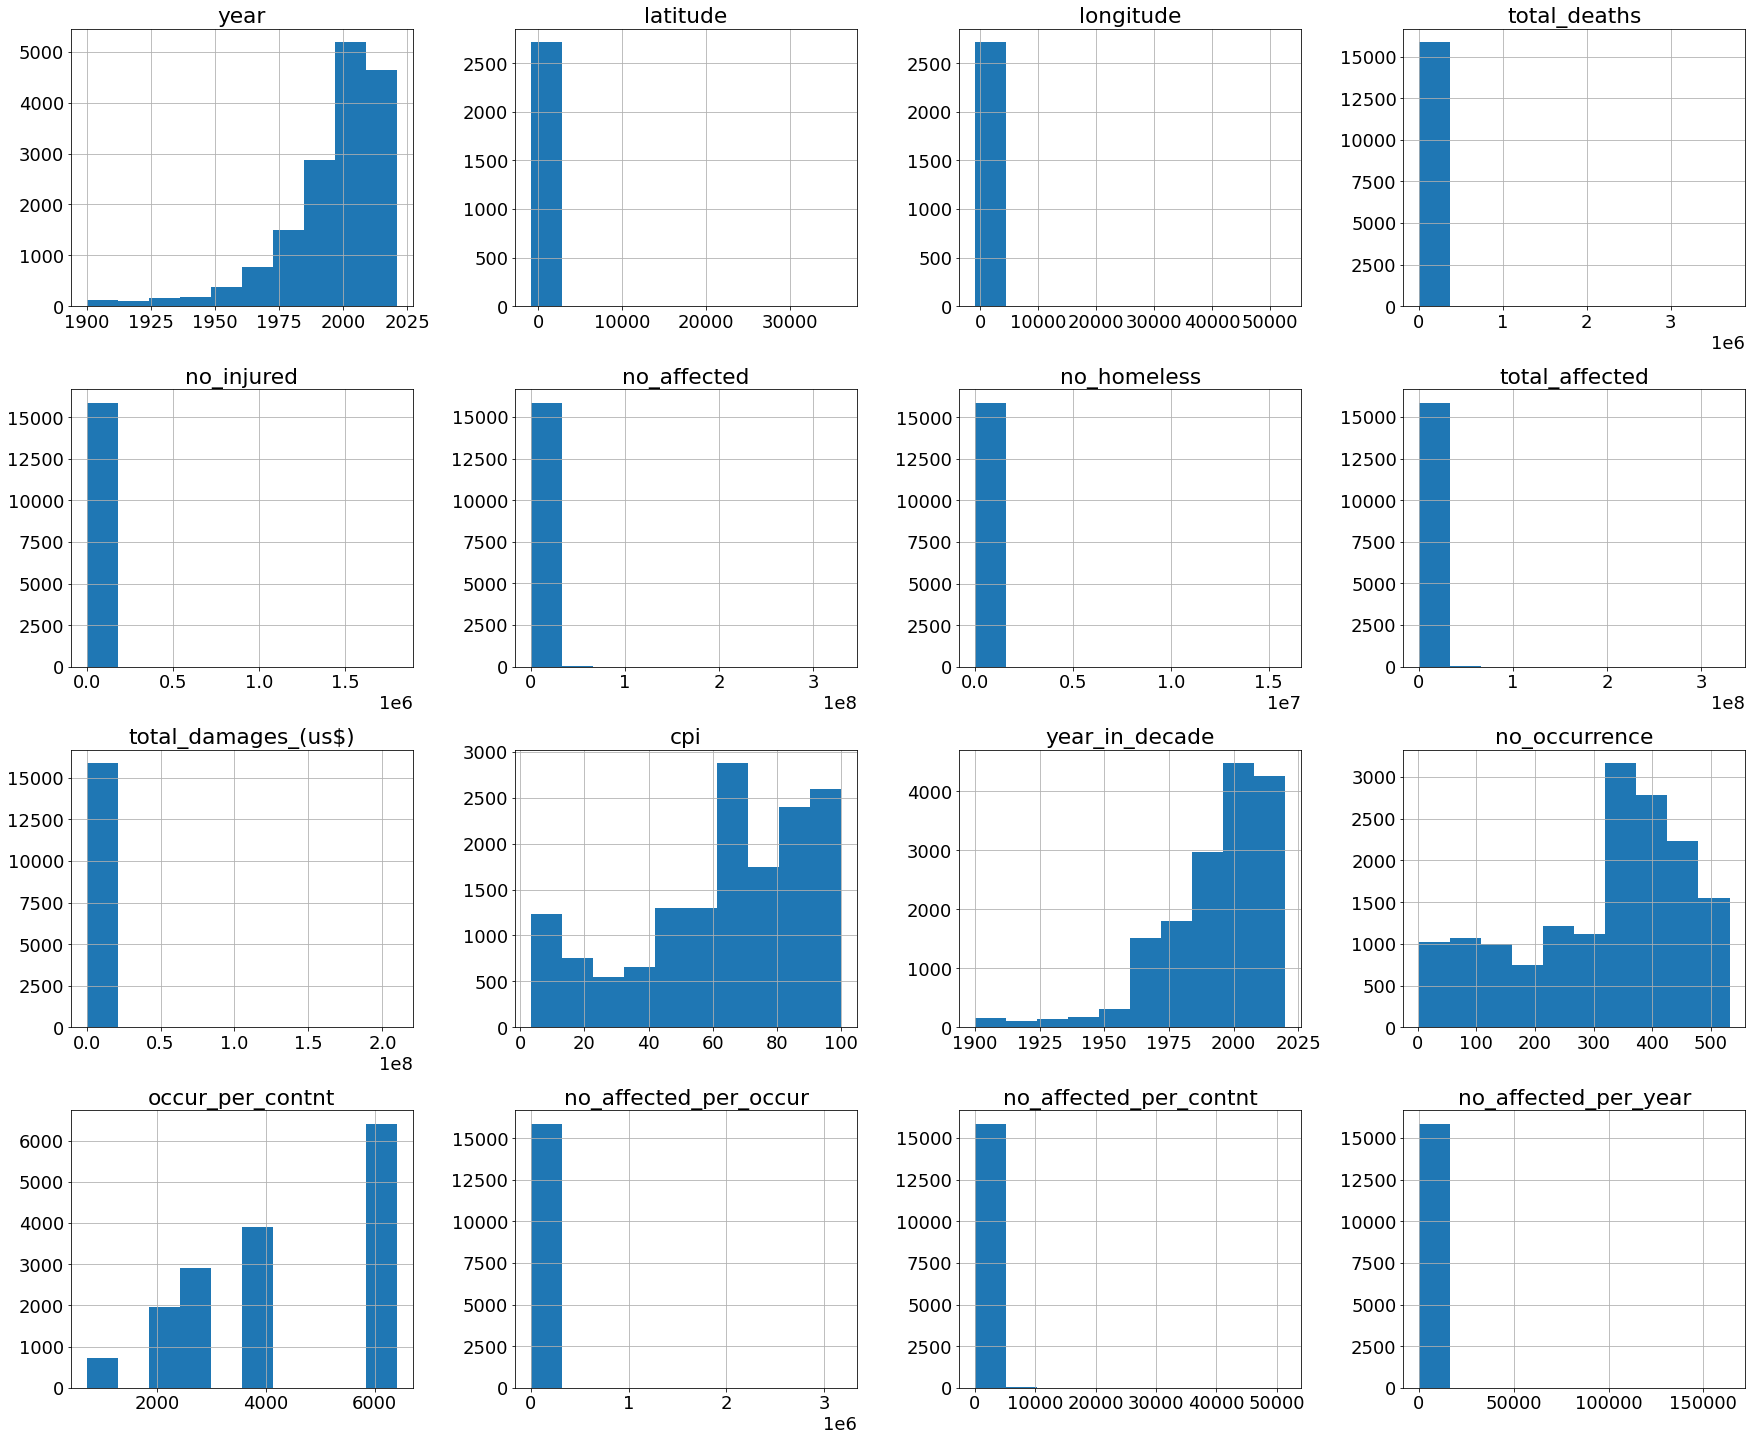

In [15]:
df.drop(['start_month', 'local_hour'], axis = 1).hist(figsize = (30,25))
plt.show()

# Save as csv

In [15]:
df.to_csv('../data/ml_data.csv', index= False)